In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [93]:
columns = ['Order_date', 'Order_ID', 'Purchased_product_ID', 'Quantity_of_SKU_in_the_order', 'Category_ID', 'Category_alias', 'Brand_ID', 'Price', 'User_ID', 'Product_gender', 'Colour', 'Metal', 'Gem']

In [94]:
df = pd.read_csv('jewelry.csv', names=columns)

In [95]:
df.head(4)

,Order_date,Order_ID,Purchased_product_ID,Quantity_of_SKU_in_the_order,Category_ID,Category_alias,Brand_ID,Price,User_ID,Product_gender,Colour,Metal,Gem
0,2018-12-01 11:40:29 UTC,1924719191579951782,1842195256808833386,1,1.806829e+18,jewelry.earring,0.0,561.51,1.515916e+18,NaN,red,gold,diamond
1,2018-12-01 17:38:31 UTC,1924899396621697920,1806829193678291446,1,1.806829e+18,NaN,NaN,212.14,1.515916e+18,NaN,yellow,gold,NaN
2,2018-12-02 13:53:42 UTC,1925511016616034733,1842214461889315556,1,1.806829e+18,jewelry.pendant,1.0,54.66,1.515916e+18,f,white,gold,sapphire
3,2018-12-02 17:44:02 UTC,1925626951238681511,1835566849434059453,1,1.806829e+18,jewelry.pendant,0.0,88.90,1.515916e+18,f,red,gold,diamond


In [96]:
df.dtypes

Order_date                       object
Order_ID                          int64
Purchased_product_ID              int64
Quantity_of_SKU_in_the_order      int64
Category_ID                     float64
Category_alias                   object
Brand_ID                        float64
Price                           float64
User_ID                         float64
Product_gender                   object
Colour                           object
Metal                            object
Gem                              object
dtype: object

In [100]:
df['Order_date'] = df['Order_date'].apply(lambda x: x.replace(' UTC', ''))

In [101]:
df['Order_date'] = df['Order_date'].apply(pd.to_datetime)

In [110]:
df['Month_of_order'] = df['Order_date'].map(lambda x: x.strftime('%Y-%m'))

In [135]:
df['Order_date'].max()

Timestamp('2021-12-01 09:59:07')

→ Данные за декабрь 2021 неполные, уберем этот месяц из датафрейма

In [136]:
df = df.loc[df['Month_of_order'] != '2021-12']

In [137]:
orders = df.groupby(['User_ID', 'Month_of_order']).agg({'Order_ID':'count', 'Price':'sum'}) \
.rename(columns={'Order_ID':'Orders', 'Price':'Revenue'})

 ### Сколько и на какую сумму каждый месяц делают заказов?

In [138]:
orders_by_month = orders.groupby('Month_of_order').agg({'Orders':'sum', 'Revenue':'sum'}).reset_index()

In [139]:
orders_by_month.head()

,Month_of_order,Orders,Revenue
0,2018-12,122,33935.77
1,2019-01,566,191471.91
2,2019-02,779,240286.89
3,2019-03,636,216889.54
4,2019-04,673,229081.68


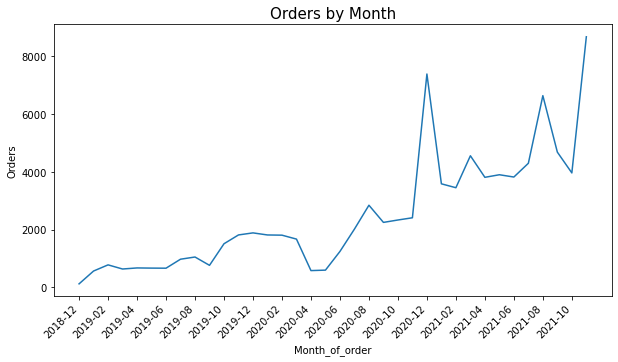

In [263]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=orders_by_month, x='Month_of_order',y='Orders')
plt.xticks(
    orders_by_month['Month_of_order'].iloc[::2],
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
);
plt.title("Orders by Month", fontsize = 15);

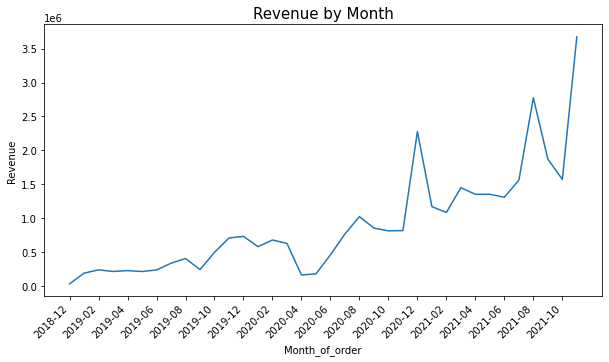

In [262]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=orders_by_month, x='Month_of_order',y='Revenue')
plt.xticks(
    orders_by_month['Month_of_order'].iloc[::2],
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
);
plt.title("Revenue by Month", fontsize = 15);

### В какие месяцы чаще всего делают заказы?

In [176]:
orders_distribution = df.groupby(df['Order_date'].dt.month).agg({'Order_ID':'count'}) \
.rename(columns={'Order_ID':'Orders', 'Order_date':'Month'}).reset_index()

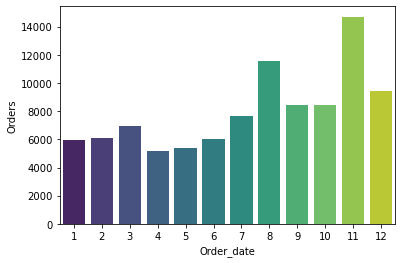

In [261]:
sns.barplot(data=orders_distribution, x='Order_date', y='Orders', palette='viridis');

### В какие дни недели совершается больше всего покупок?

In [192]:
df['Day_of_week'] = df['Order_date'].dt.day_name()
products_by_days = df.groupby(['Day_of_week'], as_index=False).agg({'Order_ID':'count'})

In [194]:
products_by_days.head()

,Day_of_week,Order_ID
0,Friday,14343
1,Monday,12779
2,Saturday,13569
3,Sunday,12690
4,Thursday,15097


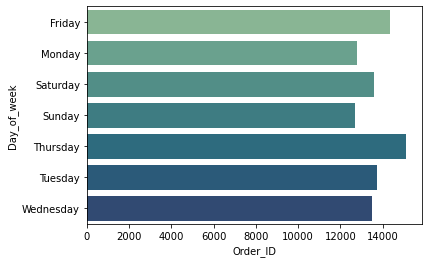

In [260]:
sns.barplot(x="Order_ID", y='Day_of_week', data=products_by_days, palette='crest');

### ARPU по годам

In [242]:
ARPU = df.groupby(df['Order_date'].dt.year).agg({'User_ID':'nunique', 'Price':'sum'}).reset_index()
ARPU['ARPU'] = ARPU['Price'] / ARPU['User_ID']
ARPU

,Order_date,User_ID,Price,ARPU
0,2018,66,33935.77,514.178333
1,2019,2714,4264680.39,1571.363445
2,2020,8971,9262282.30,1032.469323
3,2021,22032,19180836.22,870.589879


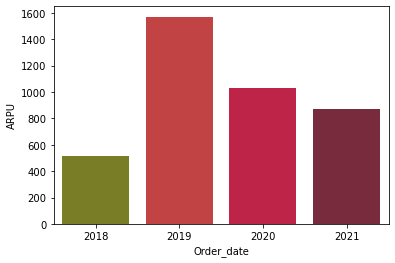

In [259]:
sns.barplot(data=ARPU, x='Order_date', y='ARPU', palette='prism_d');

### Когортный анализ пользователей

In [209]:
first_order = df.groupby('User_ID', as_index=False).agg({'Order_date':'min'}).rename(columns={'Order_date':'First_order'})

In [210]:
df = df.merge(first_order, on='User_ID')

In [211]:
df['Date_diff'] = (df['Order_date'] - df['First_order']).dt.days

In [212]:
df['Cohort_period'] = pd.cut(df['Date_diff'], [-1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 100000], 
                             labels=['0 day', '30 d', '60 d', '90 d', '120 d', '150 d', '180 d', '210 d', '240 d', '270 d', '300 d', '330 d', '360 d', '>360 d'])

In [314]:
cohort_size = df.groupby(df['First_order'].dt.to_period('M')).agg({'User_ID':'nunique'}).reset_index()

In [315]:
cohort_size.head()

,First_order,User_ID
0,2018-12,66
1,2019-01,188
2,2019-02,212
3,2019-03,206
4,2019-04,153


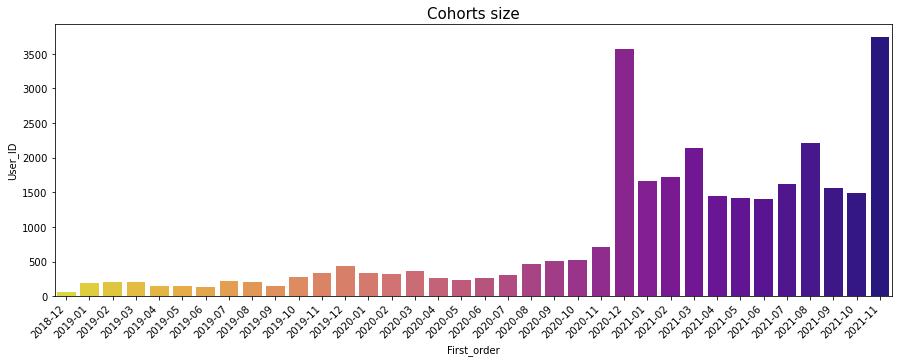

In [307]:
plt.figure(figsize=(15, 5))
sns.barplot(data=cohort_size, x='First_order', y='User_ID', palette='plasma_r')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light'
);
plt.title("Cohorts size", fontsize = 15);

In [213]:
cohort_0 = df.query("Cohort_period=='0 day'").groupby(df['First_order'].dt.to_period('M')).agg({'User_ID':'nunique'})['User_ID']

In [215]:
cohorts = df.groupby([df['First_order'].dt.to_period('M'), 'Cohort_period']).agg({'User_ID':'nunique'}).reset_index()

In [216]:
cohorts = cohorts.pivot(index=['First_order'], columns=['Cohort_period'], values=['User_ID'])

In [217]:
cohorts = cohorts.divide(cohort_0, axis=0)

In [221]:
cohorts.background_gradient(cmap='viridis').format("{:.2%}", na_rep="")

### RFM анализ
__R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.__

In [222]:
last_date = df['Order_date'].max()

In [223]:
df['Days_since_order'] = (last_date - df['Order_date']).dt.days

In [224]:
rfm_df = df.groupby('User_ID', as_index=False).agg({
                                     'Order_date': lambda x: (last_date - x.max()).days,
                                     'Order_ID': lambda x: len(x),
                                     'Price': lambda x: x.sum()})

In [225]:
rfm_df.rename(columns={'Order_date':'Recency', 'Order_ID':'Frequency', 'Price':'Monetary'}, inplace=True)

In [226]:
quintiles = rfm_df[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 64.0, 0.4: 166.0, 0.6: 276.0, 0.8: 352.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 2.0},
 'Monetary': {0.2: 142.2, 0.4: 259.97, 0.6: 431.37, 0.8: 868.29}}

In [227]:
rfm_df['R'] = pd.qcut(rfm_df['Recency'], 5, labels=[1, 2, 3, 4, 5])

In [228]:
rfm_df['F'] = pd.cut(rfm_df['Frequency'], 5, labels=[5, 4, 3, 2, 1])

In [229]:
rfm_df['M'] = pd.qcut(rfm_df['Monetary'], 5, labels=[5, 4, 3, 2, 1])

In [230]:
rfm_df['RFM'] = rfm_df['R'].astype(str) + rfm_df['F'].astype(str) + rfm_df['M'].astype(str)

In [231]:
rfm_df.head()

,User_ID,Recency,Frequency,Monetary,R,F,M,RFM
0,1.313554e+18,521,1,272.47,5,5,3,553
1,1.313556e+18,56,6,3818.79,1,5,1,151
2,1.313566e+18,103,5,2814.39,2,5,1,251
3,1.313582e+18,134,1,130.00,2,5,5,255
4,1.313591e+18,435,8,2067.09,5,5,1,551


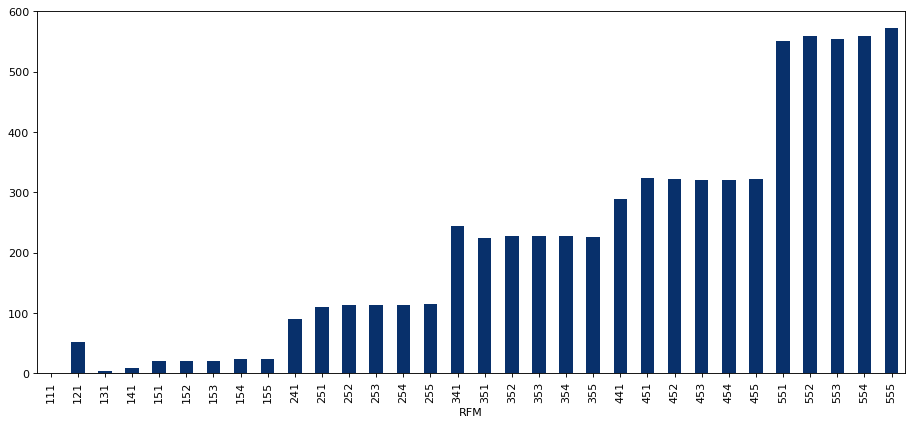

In [232]:
fig=plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
rfm_df.groupby('RFM').agg('Recency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()